In [1165]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.linalg import block_diag
from scipy import linalg
import control
import matplotlib.colors as colors
from matplotlib import style
from matplotlib.patches import Rectangle
from numpy.linalg import matrix_power
import cvxpy as cp

In [1166]:
# finding the value of Gamma_k, a helper
def Gamma(F,G,K,k):
    Gamma_k = np.zeros(F.shape)
    for h in range(k+1):
        Gamma_k += - matrix_power(F - G @ K, h) @ G @ K @ matrix_power(F - G @ K, k-h)
    return Gamma_k

In [1167]:
# calculating constant values \mathcal A1, A2 of J_c(x_0')
def A1_and_A2(F,G,K,Q,R,N):
    A1 = Gamma(F,G,K,N-1).T @ Q @ Gamma(F,G,K,N-1)
    F_K = F - G @ K
    A2 = matrix_power(F_K,N).T @ Q @ Gamma(F,G,K,N-1) 
    for k in range(N):
        A1 += Gamma(F,G,K,k-1).T @ Q @ Gamma(F,G,K,k-1) + (matrix_power(F_K,k) + 
                Gamma(F,G,K,k-1)).T @ K.T @ R @ K @ (matrix_power(F_K,k) + Gamma(F,G,K,k-1))
        A2 += matrix_power(F_K,k).T @ (Q @ Gamma(F,G,K,k-1) + K.T @ R @ K @ (matrix_power(F_K,k) + Gamma(F,G,K,k-1)))
    return A1/N, A2/N


In [1168]:
def terminal_constraints(F,G,K,N,P):
    F_K = F - G @ K
    X1 = np.concatenate((Gamma(F,G,K,N-1),matrix_power(F_K,N)), axis=0)
    X2 = np.concatenate((matrix_power(F_K,N), np.zeros(F.shape)), axis=0)

    I1 = X1.T @ P @ X1
    I2 = 2 * X2.T @ P @ X1
    I3 = X2.T @ P @ X2
    return I1, I2, I3

In [1169]:
def big_covariance_Sigma(F,G,K,H,L,Sigma_v,Sigma_w):
    Phi1 = np.concatenate((F - L @ H, np.zeros(F.shape)), axis=1)
    Phi2 = np.concatenate((L @ H, F - G @ K), axis=1)
    Phi = np.concatenate((Phi1,Phi2), axis=0)
    
    Psi1 = np.concatenate((np.eye(F.shape[0]), -L), axis=1)
    Psi2 = np.concatenate((np.zeros(F.shape), L), axis=1)
    Psi = np.concatenate((Psi1,Psi2), axis=0)
    
    Omega = block_diag(Sigma_w,Sigma_v)
    Sigma = linalg.solve_discrete_lyapunov(Phi, Psi @ Omega @ Psi.T)
    return Sigma
    
def lyapunov_matrix_P(F,G,K,Q0):
    A1 = np.concatenate((F - G @ K, -G @ K), axis=1)
    A2 = np.concatenate((np.zeros(F.shape), F - G @ K), axis=1)
    AT = np.concatenate((A1,A2), axis=0)
    A = AT.T
    P = linalg.solve_discrete_lyapunov(A, Q0)
    return P

In [1170]:
b = np.array([[1]])
a = np.array([[2]])
np.concatenate((a,b), axis=0)

array([[2],
       [1]])

In [1171]:
def x_hat_update(y0,F,G,H,L,x00,u): 
    x11 = F @ x00 + G @ u + L @ (y0 - H @ x00) 
    return x11

def x_true_update(x0,F,G,u,H,Sigma_w,Sigma_v):
    x1 = F @ x0 + G @ u + np.sqrt(Sigma_w) @ np.random.randn(x0.shape[0],1)
    y0 = H @ x0 + np.sqrt(Sigma_v) @ np.random.randn(H.shape[0],1)
    return x1, y0

In [1262]:
# State dynamics
F=np.array([[1,0.0075],[-0.143,0.996]])
G=np.array([[4.798,0.115]]).T
H=np.array([[1,0],[0,1]])

mu_x0=-np.array([[0.6455,1.3751]]).T
#mu_x0=np.random.randn(2,1)
Sigma_w=np.diag(np.array([0.1,0.1]))
Sigma_v=1*np.diag(np.array([0.1,0.1]))
# LQR: costs and gain
Q=1 * np.diag([2,1])
R=1 * np.eye(G.shape[1])
K, _, _ = control.dlqr(F, G, Q, R)
L, _, _ = control.dlqe(F, np.eye(F.shape[0]), H, Sigma_w, Sigma_v)
#L = (F - G @ K) @ L # One-step ahead predictor
# N: prediction horizon, T: horizon, epsilon: tolerance
N=16
T_horizon=100
epsilon=0.2
Q0 = 0.1 * np.eye(2 * F.shape[0])
P = lyapunov_matrix_P(F,G,K,Q0)
I1, I2, I3 = terminal_constraints(F,G,K,N,P)
Sigma = big_covariance_Sigma(F,G,K,H,L,Sigma_v,Sigma_w)
I_I = np.concatenate((np.eye(F.shape[0]),np.eye(F.shape[0])), axis=1)
K_0 = K @ np.concatenate((np.zeros(F.shape), np.eye(F.shape[0])), axis=1)
Sigma_x = I_I @ Sigma @ I_I.T
#Sigma_x = 0.01 * np.diag(np.array([0.1,0.1]))
Sigma_u = K_0 @ Sigma @ K_0.T
# Constraints
T=np.array([[1,0]])
S=np.array([[0]])
xBar=np.array([[2]]).T
uBar=10 ** 8

# Few parameters
n=F.shape[0]
t=T.shape[0]
m=S.shape[0]

c=0.3
# Calculate A1 and A2
A1, A2 = A1_and_A2(F,G,K,Q,R,N)

In [1263]:
1/(np.sqrt(np.linalg.eig(P)[0].max()/c))

0.5491837174096956

In [1264]:
np.sqrt((t-epsilon)/epsilon)*np.sqrt(np.diag(T@Sigma_x@T.T).reshape(t,1))

array([[1.43908519]])

0
[-1.41188343 -2.40062179]
1
[-1.13948875 -1.90504018]
2
[-0.71666794 -1.16337065]
3
[-1.01845665 -1.69042098]
4
[-0.99963363 -1.65724471]
5
[-1.35398644 -2.29021778]
6
[-1.37598183 -2.33956993]
7
[-1.05855234 -1.79985675]
8
[-0.95391603 -1.62194026]
9
[-0.56361336 -0.95830857]
10
[-0.61854389 -1.05170496]
11
[-1.02944751 -1.75036849]
12
[-0.99048584 -1.68412051]
13
[-0.86918294 -1.47786864]
14
[-0.97211187 -1.65287886]
15
[-0.44661743 -0.75938206]
16
[0.24064965 0.40918644]
17
[0.51033059 0.86770788]
18
[0.81724135 1.38955277]
19
[0.87985242 1.49601277]
20
[1.333186   2.11062206]
21
[1.18202592 1.9374167 ]
22
[0.66602186 1.1324346 ]
23
[0.76856262 1.30679215]
24
[0.74043564 1.25896525]
25
[1.21987898 1.99044481]
26
[0.59149835 1.00572318]
27
[0.58726838 0.9985311 ]
28
[0.49534914 0.8422288 ]
29
[0.36174621 0.61505456]
30
[0.83035349 1.4118478 ]
31
[0.78866359 1.34096201]
32
[1.36950535 2.16228548]
33
[1.34664424 2.13696818]
34
[1.4243917  2.22142969]
35
[1.32368957 2.10757975]
36
[0.

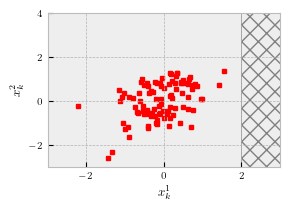

In [1298]:

plt.style.use('bmh')
fig= plt.figure(figsize=(3.0,2.0))
rectangle = plt.Rectangle((2,-10), 20, 20, fc='None',ec="grey", hatch='xx',zorder=1)
plt.gca().add_patch(rectangle)

plt.xticks(fontsize=7)  
plt.yticks(fontsize=7)  
plt.xlabel('$x^1_k$', fontsize=9)  
plt.ylabel('$x^2_k$', fontsize=9) 

plt.rc( 'text', usetex=True )

x0_prime_rec = np.full((n, T_horizon), np.nan)
x0_hat_rec = np.full((n, T_horizon), np.nan)

x0_hat = mu_x0
x0_true = np.sqrt(Sigma_x)@np.random.randn(n,1) + mu_x0
x0_true_rec=np.full((n, T_horizon), np.nan)
y1s=np.full((T_horizon, ), np.nan)
for k in range(T_horizon):
    print(k)
    x0_hat_rec[:,k] = x0_hat.squeeze()
    x0_true_rec[:,k] = x0_true.squeeze()
    x0_bar = x0_hat
    plt.plot(x0_true[0],x0_true[1],'sr',ms=2.5,zorder=1)
    # Construct the optimization problem over xo' and xo'':
    x0_prime = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(x0_prime, A1) + 2 * x0_bar.T @ A2 @ x0_prime)
    
    constraints = []
    for kk in range(1,N+1):
        A_constraints = T @ Gamma(F,G,K,kk-1)
        b_constraints = -T @ matrix_power(F-G@K,kk) @ x0_bar + \
            xBar-np.sqrt((t-epsilon)/epsilon)*np.sqrt(np.diag(T@Sigma_x@T.T).reshape(t,1))
        constraints += [A_constraints @ x0_prime <= b_constraints]

    constraints += [cp.quad_form(x0_prime, I1) + x0_bar.T @ I2 @ x0_prime <= c - x0_bar.T @ I3 @ x0_bar]
    prob = cp.Problem(objective, constraints)#)#, constraints)
    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve(solver=cp.ECOS)
    # The optimal value for x is stored in `x.value`.
    x0star = x0_prime.value
    #if x0_hat[1] >= 0:
    #    x0star[1] = -x0_hat[1]
    x0_prime_rec[:,k] = x0star.squeeze()
    u = - K @ (x0star + x0_hat.squeeze())
    u = np.array([u])
    x0_true, y0 = x_true_update(x0_true,F,G,u,H,Sigma_w,Sigma_v)
    #plt.plot(x0_true[0],x0_true[1],'*b',ms=2,zorder=2)
    x0_hat = x_hat_update(y0,F,G,H,L,x0_hat,u)
    print(x0star)
    #plt.plot(x0_true[0]+x0star[0],x0_true[1]+x0star[1],'.k')
plt.xlim([-3, 3])
plt.ylim([-3, 4]) 

plt.savefig('figs/LinearStateSelection.pdf',bbox_inches ="tight")
plt.xticks(fontsize=7)  
plt.yticks(fontsize=7) 

plt.show()


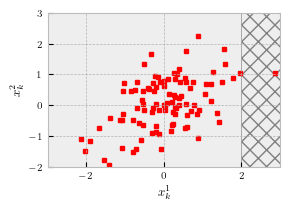

In [1306]:
# Plotting
#With particle filter conditional mean
plt.style.use('bmh')
fig= plt.figure(figsize=(3.0,2.0))
rectangle = plt.Rectangle((2,-10), 20, 20, fc='None',ec="grey", hatch='xx',zorder=1)
plt.gca().add_patch(rectangle)

plt.xticks(fontsize=7)  
plt.yticks(fontsize=7)  
plt.xlabel('$x^1_k$', fontsize=9)  
plt.ylabel('$x^2_k$', fontsize=9) 
plt.xlim([-3, 3])
plt.ylim([-2, 3])

# Initialize algorithm
x0_hat = mu_x0
x0_true=np.sqrt(Sigma_x)@np.random.randn(n,1)+mu_x0
y1s=np.full((T_horizon,),np.nan)
for k in range(T_horizon):
    plt.plot(x0_true[0],x0_true[1],'sr',ms=3,zorder=1)
    # Construct the problem.
    u = -np.array((K @ x0_hat).reshape(1,1))
    x0_true, y0 = x_true_update(x0_true,F,G,u,H,Sigma_w,Sigma_v)
    #y1s[k]=y1
    x0_hat = x_hat_update(y0,F,G,H,L,x0_hat,u)
    #plt.plot(x0_true[0],x0_true[1],'.k')

plt.savefig('figs/LinearStateSpaceLQROnly.pdf',bbox_inches ="tight")
plt.show()


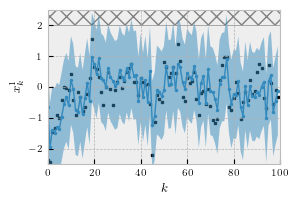

In [1308]:
plt.style.use('bmh')
fig= plt.figure(figsize=(3.0,2.0))
rectangle = plt.Rectangle((-1,2), 500, 20, fc='None',ec="grey", hatch='xx',zorder=1)
plt.gca().add_patch(rectangle)
sigmas=np.sqrt(Sigma_x)[0,0]
k=range(T_horizon)
x=x0_hat_rec[0,:].reshape(T_horizon,)
nn=2
y1 = x-nn*sigmas
y2 = x+nn*sigmas

# plot
plt.xticks(fontsize=7)  
plt.yticks(fontsize=7)  
plt.xlabel('$k$', fontsize=9)  
plt.ylabel('$x^1_k$', fontsize=9) 

plt.fill_between(k, y1, y2, alpha=.5, linewidth=0)
plt.plot(k, x, '-o', ms=1.5 , linewidth=1)
plt.plot(k,x0_true_rec[0,:],'sk',ms=2,linewidth=1,zorder=0)
plt.xlim([0, 100])
plt.ylim([-2.5, 2.5])
plt.savefig('figs/Linear2Sigmas.pdf',bbox_inches ="tight")
plt.show()